In [1]:
# Cell 1: Imports, NLTK Downloads, and Module Reloading
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import sys 
from nltk.corpus import stopwords 
import importlib  # <-- ADD THIS IMPORT

# Add the 'src' directory to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

try:
    from src import preprocessor
    # **THIS IS THE FIX**: Force reload the module
    importlib.reload(preprocessor) 
    print("Successfully imported and reloaded preprocessor module.")
except ImportError as e:
    print(f"Error importing preprocessor: {e}")

# Download NLTK data
print("Downloading NLTK data ('punkt' and 'stopwords')...")
nltk.download('punkt')
nltk.download('stopwords')
print("NLTK data download complete.")

# Load stopwords into a variable
stop_words = set(stopwords.words('english'))
print(f"Loaded {len(stop_words)} stopwords.")

Successfully imported and reloaded preprocessor module.
NLTK data download complete.
Loaded 198 stopwords.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zeel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zeel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Cell 2: Load Raw Data
# Path is relative to the notebook (go up one folder, then down)
RAW_DATA_PATH = '../data/raw/reddit-posts.json'
PROCESSED_DATA_PATH = '../data/processed/cleaned-posts.csv'

try:
    df = pd.read_json(RAW_DATA_PATH)
    print(f"Successfully loaded {len(df)} posts from {RAW_DATA_PATH}")
    print(df.head())
except Exception as e:
    print(f"Error loading {RAW_DATA_PATH}: {e}")

Successfully loaded 1193 posts from ../data/raw/reddit-posts.json
        id                                              title  \
0  1nq5b7a  There's Over 1 Million AI Influencers Already ...   
1  1j0mjze    How to Create Profitable AI Influencers in 2025   
2  1gc7syt                                      **IMPORTANT**   
3  1dzjxq8              Viral/Controversial Instagram Moments   
4  16nljql  📢 Calling all digital enthusiasts! 🌐 [VIRTUAL ...   

                                                text              subreddit  \
0  If you think **AI influencers** are not workin...  digitalproductselling   
1  AI influencers are AI-generated personalities ...         AISideHustlers   
2  There is a game Called Paradise that is scammi...            DarkViperAU   
3  White text means controversial, pink text mean...          IcebergCharts   
4  Are you intrigued by the world of virtual infl...      VirtualInfluencer   

   score  num_comments  created_utc         created_date search_quer

In [3]:
#Cell 3: NLTK Data Download Script
import nltk

# Force all NLTK downloads required for tokenization and stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')   # <-- NEW important one (added in recent NLTK versions)

print("✅ All NLTK data downloaded successfully.")


✅ All NLTK data downloaded successfully.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zeel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zeel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zeel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Cell 4: Apply Text Cleaning (Clean and Tokenize)
if 'df' in locals():
    print("Applying text cleaning (Step 1: clean_text)...")
    df['cleaned_text'] = df['text'].apply(preprocessor.clean_text)
    
    print("Applying tokenization and stopword removal (Step 2: tokenize_and_remove_stopwords)...")
    
    # This lambda function is correct.
    # It will now call the reloaded version of the preprocessor.
    df['tokens'] = df['cleaned_text'].apply(
        lambda text: preprocessor.tokenize_and_remove_stopwords(text, stop_words_set=stop_words)
    )
    
    # Create a space-joined version for TF-IDF
    df['tokens_joined'] = df['tokens'].apply(lambda x: ' '.join(x))
    
    print("\n--- Checkpoint: Data after processing ---")
    print(df[['text', 'cleaned_text', 'tokens_joined']].head())
    
    # Checkpoint: Verify URLs are gone
    has_urls = df['cleaned_text'].str.contains('http').any()
    print(f"\nCheckpoint: CSV has no URLs? {not has_urls}")

Applying text cleaning (Step 1: clean_text)...
Applying tokenization and stopword removal (Step 2: tokenize_and_remove_stopwords)...

--- Checkpoint: Data after processing ---
                                                text  \
0  If you think **AI influencers** are not workin...   
1  AI influencers are AI-generated personalities ...   
2  There is a game Called Paradise that is scammi...   
3  White text means controversial, pink text mean...   
4  Are you intrigued by the world of virtual infl...   

                                        cleaned_text  \
0  if you think ai influencers are not working or...   
1  ai influencers are aigenerated personalities t...   
2  there is a game called paradise that is scammi...   
3  white text means controversial pink text means...   
4  are you intrigued by the world of virtual infl...   

                                       tokens_joined  
0  think ai influencers working super early youre...  
1  ai influencers aigenerated personalit

In [5]:
# Cell 5: Extract TF-IDF Features
if 'df' in locals():
    print("Extracting TF-IDF features...")
    
    # Initialize the TF-IDF Vectorizer
    # We limit features to the top 2000 most frequent terms
    tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
    
    # Fit and transform the tokenized text
    tfidf_features = tfidf_vectorizer.fit_transform(df['tokens_joined'])
    
    print("TF-IDF extraction complete.")
    print(f"Shape of TF-IDF matrix: {tfidf_features.shape}")
    
    # You can inspect the feature names (words)
    # print("\nSample of TF-IDF feature names:")
    # print(tfidf_vectorizer.get_feature_names_out()[100:110])

Extracting TF-IDF features...
TF-IDF extraction complete.
Shape of TF-IDF matrix: (1193, 2000)


In [6]:
# Cell 6: Save Processed CSV File
if 'df' in locals():
    # We save the cleaned data. We don't save the sparse TF-IDF matrix to this CSV.
    # The TF-IDF vectorizer will be re-run in the modeling notebook.
    
    # Select columns to save
    df_to_save = df[['id', 'title', 'cleaned_text', 'tokens_joined']]
    
    # Ensure the 'processed' directory exists
    os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
    
    df_to_save.to_csv(PROCESSED_DATA_PATH, index=False, encoding='utf-8')
    print(f"Processed data successfully saved to: {PROCESSED_DATA_PATH}")

Processed data successfully saved to: ../data/processed/cleaned-posts.csv


Generating quick plots...


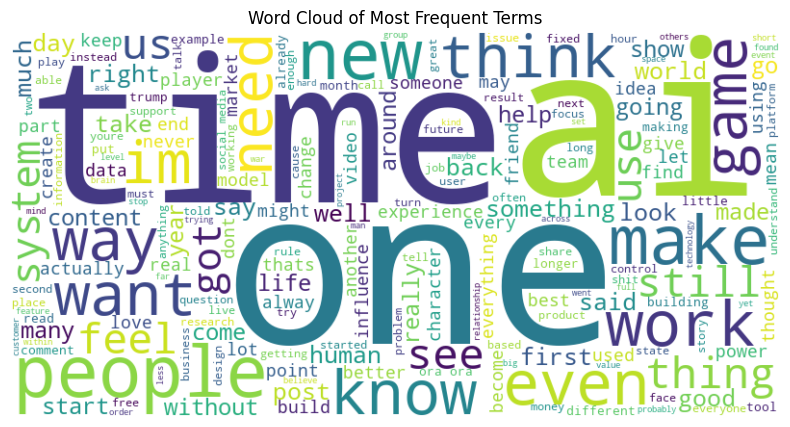

<Figure size 1200x800 with 0 Axes>

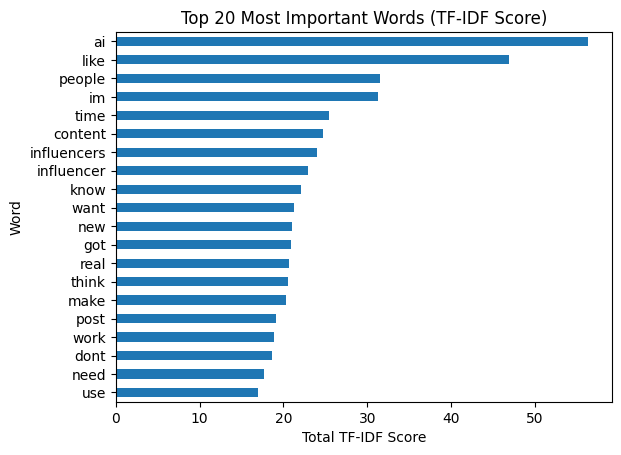

In [7]:
# Cell 7: Quick Plots (EDA)
if 'df' in locals():
    print("Generating quick plots...")
    
    # --- 1. Word Cloud ---
    # Combine all tokens into one giant string
    all_words = ' '.join(df['tokens_joined'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of Most Frequent Terms')
    plt.axis('off')
    plt.show()

    # --- 2. Top 20 Words Bar Chart (from TF-IDF) ---
    # We can use the vectorizer we already created
    sum_words = tfidf_features.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    top_20 = words_freq[:20]
    
    top_df = pd.DataFrame(top_20, columns=['Word', 'TF-IDF_Score'])
    
    plt.figure(figsize=(12, 8))
    top_df.sort_values(by='TF-IDF_Score').plot(kind='barh', x='Word', y='TF-IDF_Score', legend=False,
                                              title='Top 20 Most Important Words (TF-IDF Score)')
    plt.xlabel('Total TF-IDF Score')
    plt.ylabel('Word')
    plt.show()